In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import os
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np

# Path to the positive images directory
positive_images_dir = '/content/drive/MyDrive/data/train/pos'

# Path to the negative images directory
negative_images_dir = '/content/drive/MyDrive/data/train/neg'

# Path to the directory where you want to save the trained classifier
output_dir = '/content/drive/MyDrive/data/claasifier'

# Path to the cascade classifier XML file
cascade_xml_file = '/content/drive/MyDrive/data/claasifier/haarcascade_frontalface_default.xml'

In [3]:
positive_samples_file = 'positive_samples.txt'
with open(positive_samples_file, 'w') as file:
    for filename in os.listdir(positive_images_dir):
        if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.bmp'):
            file.write(os.path.join(positive_images_dir, filename) + ' 1 0 0 100 100\n')

negative_samples_file = 'negative_samples.txt'
with open(negative_samples_file, 'w') as file:
    for filename in os.listdir(negative_images_dir):
        if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.bmp'):
            file.write(os.path.join(negative_images_dir, filename) + '\n')

In [4]:
num_processes = multiprocessing.cpu_count()

num_stages = 20
min_hit_rate = 0.999
max_false_alarm_rate = 0.5
num_positives = 550
num_negatives = 1100
width = 100
height = 100

def train_classifier(process_id):
    command = f'opencv_traincascade -data {output_dir}_process_{process_id} -vec {positive_samples_file} -bg {negative_samples_file} ' \
              f'-numStages {num_stages} -minHitRate {min_hit_rate} -maxFalseAlarmRate {max_false_alarm_rate} ' \
              f'-numPos {num_positives} -numNeg {num_negatives} -w {width} -h {height} -featureType LBP ' \
              f'-numThreads 1'
    os.system(command)

processes = []
for i in range(num_processes):
    process = multiprocessing.Process(target=train_classifier, args=(i,))
    process.start()
    processes.append(process)

for process in processes:
    process.join()

# Merge the resulting classifiers
merged_classifier_file = os.path.join(output_dir, 'cascade_classifier.xml')
command = f'opencv_createsamples -w {width} -h {height} -vec {positive_samples_file} -info {positive_samples_file} ' \
          f'-num {num_positives * num_processes} -w {width} -h {height} -bg {negative_samples_file}'
os.system(command)

command = f'opencv_traincascade -data {output_dir} -vec {positive_samples_file} -bg {negative_samples_file} ' \
          f'-numStages {num_stages} -minHitRate {min_hit_rate} -maxFalseAlarmRate {max_false_alarm_rate} ' \
          f'-numPos {num_positives * num_processes} -numNeg {num_negatives * num_processes} -w {width} -h {height} ' \
          f'-featureType LBP -mode ALL -precalcValBufSize 2048 -precalcIdxBufSize 2048 -numThreads {num_processes} ' \
          f'-baseFormatSave -baseFormatLoad -baseFormatSaveMode -w {width} -h {height} -mode BASIC -baseFormatSave'
os.system(command)

os.rename(os.path.join(output_dir, 'cascade_classifier.xml'), merged_classifier_file)

trained_classifier = cv2.CascadeClassifier(merged_classifier_file)

os.remove(positive_samples_file)
os.remove(negative_samples_file)

In [5]:
# Set the path to the trained classifier XML file
trained_classifier_file = '/content/drive/MyDrive/data/claasifier/cascade_classifier.xml'

# Set the path to the pretrained classifier XML file
pretrained_classifier_file = '/content/drive/MyDrive/data/claasifier/haarcascade_frontalface_default.xml'

# Set the path to the directory containing the test images
test_images_dir = '/content/drive/MyDrive/data/test'

# Load the trained classifier
trained_classifier = cv2.CascadeClassifier(trained_classifier_file)

# Load the pretrained classifier
pretrained_classifier = cv2.CascadeClassifier(pretrained_classifier_file)

trained_face_counts = []
pretrained_face_counts = []

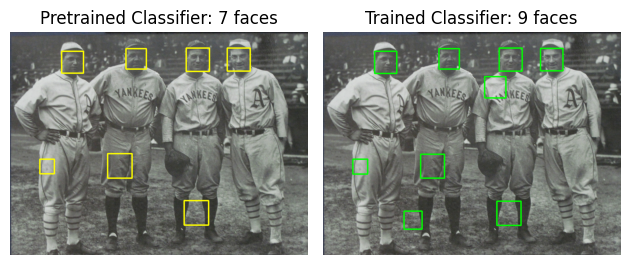

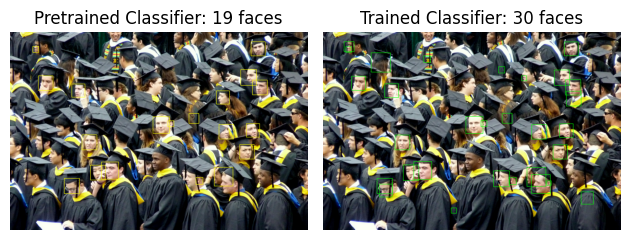

In [ ]:
# Iterate over the test images in the directory
for filename in os.listdir(test_images_dir):
    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.bmp'):
        # Read the test image
        image_path = os.path.join(test_images_dir, filename)
        test_image = cv2.imread(image_path)

        # Convert the test image to grayscale
        gray_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

        # Detect faces using the trained classifier
        trained_faces = trained_classifier.detectMultiScale(gray_image, scaleFactor=1.05, minNeighbors=5, minSize=(20, 20))

        # Get the number of faces detected by the trained classifier
        trained_face_count = len(trained_faces)
        trained_face_counts.append(trained_face_count)

        # Draw rectangles around the faces detected by the trained classifier
        for (x, y, w, h) in trained_faces:
            cv2.rectangle(test_image, (x, y), (x+w, y+h), (0, 255, 0), 3)

        # Display the test image with the face count for the trained classifier
        trained_image_with_faces = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
        plt.subplot(122)
        plt.imshow(trained_image_with_faces)
        plt.title(f'Trained Classifier: {trained_face_count} faces')
        plt.axis('off')

        # Read the test image again
        test_image = cv2.imread(image_path)

        # Detect faces using the pretrained classifier
        pretrained_faces = pretrained_classifier.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # Get the number of faces detected by the pretrained classifier
        pretrained_face_count = len(pretrained_faces)
        pretrained_face_counts.append(pretrained_face_count)

        # Draw rectangles around the faces detected by the pretrained classifier
        for (x, y, w, h) in pretrained_faces:
            cv2.rectangle(test_image, (x, y), (x+w, y+h), (0,255,255), 3)

        # Display the test image with the face count for the pretrained classifier
        pretrained_image_with_faces = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
        plt.subplot(121)
        plt.imshow(pretrained_image_with_faces)
        plt.title(f'Pretrained Classifier: {pretrained_face_count} faces')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

In [ ]:
plt.plot(trained_face_counts, label='Trained Classifier')
plt.plot(pretrained_face_counts, label='Pretrained Classifier')
plt.xlabel('Image')
plt.ylabel('Number of Faces')
plt.title('Number of Faces Detected')
plt.legend()
plt.show()

In [ ]:
# Calculate the mean
trained = np.mean(trained_face_counts)
pretrained = np.mean(pretrained_face_counts)

# Calculate the percentage improvement
percentage_improvement = (( trained-pretrained) / pretrained) * 100

# Calculate the x-axis values
x = np.arange(len(trained_face_counts))

# Set the width of the bars
bar_width = 0.35

# Set the figsize to enlarge the width of the graph
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the bar graph
trained_bars = ax.bar(x - bar_width/2, trained_face_counts, bar_width, label='Trained Classifier')
pretrained_bars = ax.bar(x + bar_width/2, pretrained_face_counts, bar_width, label='Pretrained Classifier')

# Add labels, title, and legend
ax.set_xlabel('Image')
ax.set_ylabel('Number of Faces')
ax.set_title('Number of Faces Detected')
ax.set_xticks(x)
ax.legend()

# Add value labels to the bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(trained_bars)
autolabel(pretrained_bars)

# Display the face count and percentage improvement
ax.text(0.25, 0.9, f'Trained Classifier: {trained:.2f}', transform=ax.transAxes)
ax.text(0.25, 0.95, f'Pretrained Classifier: {pretrained:.2f}', transform=ax.transAxes)
ax.text(0.25, 0.85, f'Percentage Improvement: {percentage_improvement:.2f}%', transform=ax.transAxes)

# Display the plot
plt.tight_layout()
plt.show()